In [1]:
base_path = "src/nodes"
node_name = "rag_qa"
node_folder = f"{base_path}/{node_name}"

# Config

In [2]:
import hypster
from hypster import HP

@hypster.config
def hp_config(hp: HP):    
    chunker = hp.select(["paragraph", "semantic", "text"], default="paragraph")
    
    ranker_type = hp.select(["sklearn_ranker"], default="sklearn_ranker")
    
    llm_model = hp.select({"mini" : "gpt-4o-mini", 
                           "haiku" : "claude-3-haiku-20240307",
                           "sonnet" : "claude-3-5-sonnet-20240620"}
                          ,default="mini")
    
    llm_config = {"temperature" : hp.number_input(0),
                  "max_tokens" : hp.number_input(64)}
    
    system_prompt = hp.text_input("Answer with one word only")
    
    texts_path = hp.text_input("data/raw")
    query = hp.text_input("what's the document about?")

    from src.hypernodes import HyperNode
    base_path = "src/nodes"
    ranker = HyperNode.load(f"{base_path}/{ranker_type}")
    ranker._instantiated_inputs = hp.propagate(ranker.hp_config, "ranker")

In [3]:
selections = {"llm_model" : "sonnet"}
overrides = {"ranker.top_k" : 3, "llm_config.temperature" : 0.1}

inputs = hp_config(selections=selections, overrides=overrides)

In [4]:
inputs

{'chunker': 'paragraph',
 'ranker_type': 'sklearn_ranker',
 'llm_model': 'claude-3-5-sonnet-20240620',
 'llm_config': {'temperature': 0, 'max_tokens': 64},
 'system_prompt': 'Answer with one word only',
 'texts_path': 'data/raw',
 'query': "what's the document about?",
 'base_path': 'src/nodes',
 'ranker': <src.hypernodes.HyperNode at 0x2039253bd90>}

In [5]:
globals().update(inputs)

# DAG

In [6]:
%load_ext hamilton.plugins.jupyter_magic

In [7]:
display_config = dict(output_file_path=f"{node_folder}/{node_name}_dag.png",
                      show_legend=False, orient="TB", deduplicate_inputs=True)

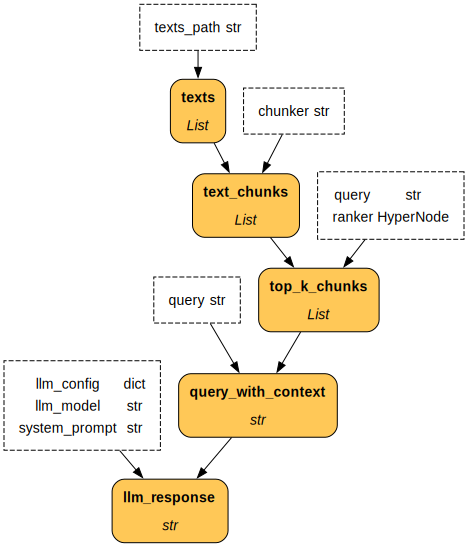

In [8]:
%%cell_to_module dag --display display_config --inputs inputs --hide_results --execute

from src.hypernodes import HyperNode
from litellm import completion
import litellm
from typing import List
import os

litellm.enable_cache()

def texts(texts_path: str) -> List[str]:
    text_files = [f for f in os.listdir(texts_path) if f.endswith('.txt')]
    text_chunks = []
    for file in text_files:
        with open(os.path.join(texts_path, file), 'r') as f:
            text_chunks.append(f.read())
    return text_chunks

def text_chunks(texts: List[str], chunker: str) -> List[str]:
    if chunker == "paragraph":
        return [chunk for text in texts for chunk in text.split("\n\n")]
    return texts

def top_k_chunks(ranker: HyperNode, text_chunks: List[str], query: str) -> List[str]:
    inputs = ranker._instantiated_inputs
    inputs.update({"text_chunks" : text_chunks, "query" : query})
    res = ranker.execute(final_vars=["top_k_chunks"], inputs=inputs)
    return res["top_k_chunks"]

def query_with_context(query: str, top_k_chunks: List[str]) -> str:
    return (
        "Here's the user query: \n"
        + query
        + "\n and here are the top k chunks: \n"
        + ", ".join(top_k_chunks)
    )

def llm_response(query_with_context: str, llm_model: str, llm_config: dict, system_prompt: str) -> str:
    messages=[{"role": "system", "content": system_prompt},
              {"role": "user", "content": query_with_context}]
    return completion(model=llm_model,
                      messages=messages,
                      **llm_config).choices[0].message.content

In [43]:
from src.hypernodes import HyperNode
node = HyperNode(name=node_name,
                 dag_modules=[dag], 
                 hp_config=hp_config)
node.save(folder=node_folder)